### Links importantes:

POR LO VISTO ESTO ES TODO FOOT ULCER

Paper:
https://www.nature.com/articles/s41598-020-78799-w#data-availability

Github del paper con datos y otras cosas más:
https://github.com/uwm-bigdata/wound-segmentation


Drive con datos:
https://drive.google.com/drive/folders/1oSjcoOqGDEKQsDBuB099mZa4sEo7jYhT

Challenge:
https://fusc.grand-challenge.org/FUSeg-2021/




En esta parte me voy a enfocar en lo siguiente:

Combiná las bases de datos que te pasé yo y las que vos encontraste y armemos primero un segmentador solamente de la úlcera. En el dataset que te pasé yo, probablemente eso implique combinar (a través de una operación de unión digamos —no intersección—) las etiquetas correspondientes a los distintos tejidos de la úlcera. Así aumentamos un poco el tamaño del dataset y hacemos una primera aproximación a tener sólo tejido de úlcera. Incluso podemos probar más adelante si sirve o no combinar datasets que trabajen con úlcera de pie diabético (y conseguimos esto que te comento, un segmentador general de úlceras que luego podemos refinar)



En primer lugar voy a cargar todo lo que tiene que ver con el nuevo dataset que segmenta de forma binaria lo que es una úlcera y lo que no.

# Conecto al Drive y creo carpetas


In [3]:
import zipfile
with zipfile.ZipFile('/content/drive/MyDrive/pIASHIBA Proyecto /Datos/Wound Care Center/azh_wound_care_center_dataset_patches.zip', 'r') as zip_ref: # Me crea las carpetas en content, a partir del .zip
    zip_ref.extractall('.')

# creo que entra al zip y me crea esas carpetas con sus archivos en content para q pueda usar (fuera de MyDrive)

Defino los paths

In [ ]:
import os 
import re
from pathlib import Path

path_train = Path('./train')
path_test = Path('./test')

path_train_images = Path('./train/images')
path_test_images = Path('./test/images')
path_train_labels = Path('./train/labels')
path_test_labels = Path('./test/labels')

#for i in os.listdir(path_train_images):
 # print(i)

## Paso imagenes de .png a .npy las imágenes y creo carpetas


Imágenes de train:

In [ ]:
from PIL import Image
import numpy as np
from numpy import asarray

# creo la carpeta images_npy dentro de train:
p = Path(path_train/'images_npy')
p.mkdir(parents=True, exist_ok=True)
# para cada foto de la carpet original, creo y cargo el .npy en la carpeta nueva
for i in os.listdir(path_train_images):
   img = Image.open(f"/content/train/images/{i}")
   numpydata = asarray(img)
   npyfile = p/i.split(".")[0]
   np.save(npyfile, numpydata)


 

In [ ]:

# creo la carpeta labels_npy dentro de train:
p2 = Path(path_train/'labels_npy')
p2.mkdir(parents=True, exist_ok=True)
# para cada foto de la carpet original, creo y cargo el .npy en la carpeta nueva
for i in os.listdir(path_train_labels):
   img = Image.open(f"/content/train/labels/{i}")
   numpydata = asarray(img)
   npyfile = p2/i.split(".")[0]
   np.save(npyfile, numpydata)


Imágenes de test:

In [ ]:
# creo la carpeta images_npy dentro de train:
p3 = Path(path_test/'images_npy')
p3.mkdir(parents=True, exist_ok=True)
# para cada foto de la carpet original, creo y cargo el .npy en la carpeta nueva
for i in os.listdir(path_test_images):
   img = Image.open(f"/content/test/images/{i}")
   numpydata = asarray(img)
   npyfile = p3/i.split(".")[0]
   np.save(npyfile, numpydata)


In [ ]:

# creo la carpeta labels_npy dentro de train:
p4 = Path(path_test/'labels_npy')
p4.mkdir(parents=True, exist_ok=True)
# para cada foto de la carpet original, creo y cargo el .npy en la carpeta nueva
for i in os.listdir(path_test_labels):
   img = Image.open(f"/content/test/labels/{i}")
   numpydata = asarray(img)
   npyfile = p4/i.split(".")[0]
   np.save(npyfile, numpydata)


## Hago que coincidan los indices de las imagenes con sus labels, tanto para train como para test


Para train:

Creo imgs_train y masks_train. Lista con los path de los archivos en el mismo orden


In [ ]:
# guardo en una variable los paths (objeto PosixPath iterando por i que toma cada nombre de los archivos dentro de images_npy)
imgs_train = [path_train/"images_npy"/i for i in os.listdir(path_train/"images_npy")]

# Creo lista de strings con los indices o nombres de los archivos.
ixs_train_referencia = [i.split('.')[0] for i in os.listdir(path_train/"images_npy")] # aca se da q mi indice es = a todo el nombre. 

# aca hago las máscaras coincidan en orden con los ixs de las imgs.
masks_train = [path_train/"labels_npy"/f'{ix}.npy' for ix in ixs_train_referencia]

masksBinaryX1 = [path_train/'labels_bin_npy'/f'{ix}.npy' for ix in ixs_train_referencia]


len(imgs_train), len(masks_train)

(831, 831)

Grafico para chequear que coincidan:

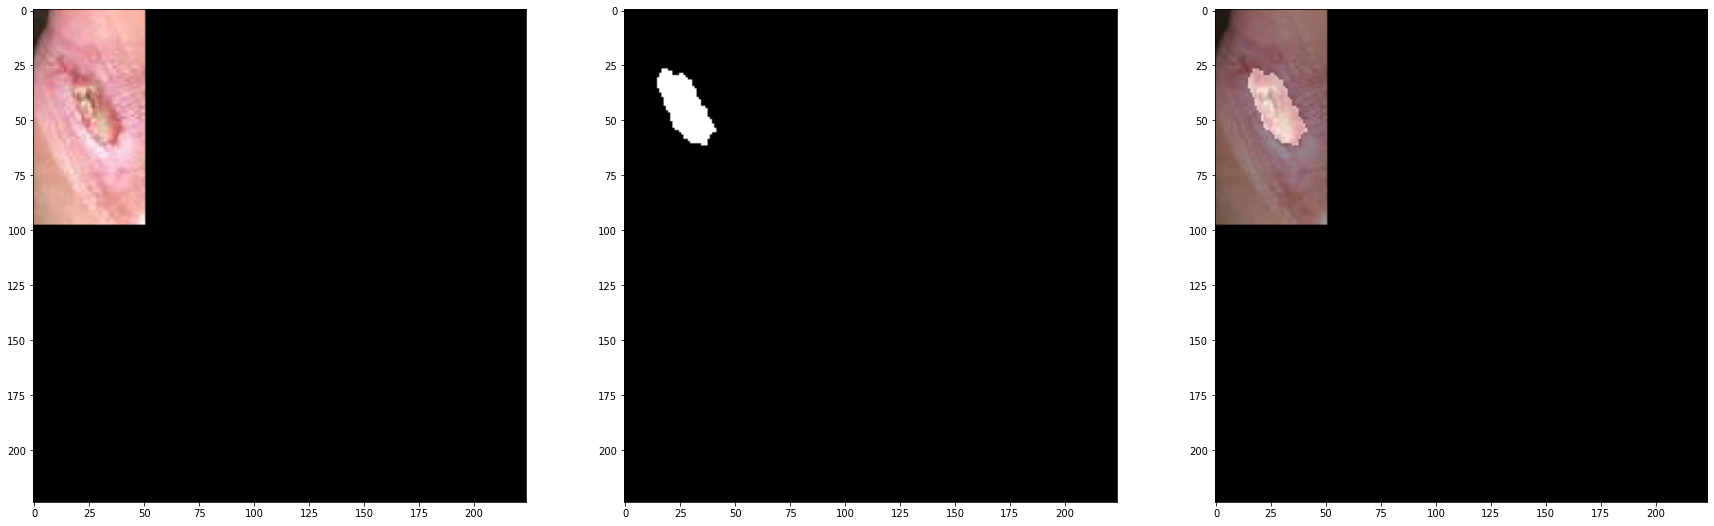

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30,10))
nroImg = 2
img = np.load(imgs_train[nroImg])
mask = np.load(masks_train[nroImg])


ax1.imshow(img)
ax2.imshow(mask)
ax3.imshow(img)
ax3.imshow(mask, alpha=0.4)
plt.show()

Para test:

Creo imgs_test y masks_test. Lista con los path de los archivos en el mismo orden

In [ ]:
# guardo en una variable los paths (objeto PosixPath iterando por i que toma cada nombre de los archivos dentro de images_npy)
imgs_test = [path_test/"images_npy"/i for i in os.listdir(path_test/"images_npy")]

# Creo lista de strings con los indices o nombres de los archivos.
ixs_test_referencia = [i.split('.')[0] for i in os.listdir(path_test/"images_npy")] # aca se da q mi indice es = a todo el nombre. 

# aca hago las máscaras coincidan en orden con los ixs de las imgs.
masks_test = [path_test/"labels_npy"/f'{ix}.npy' for ix in ixs_test_referencia]


len(imgs_test), len(masks_test)

(278, 278)

Grafico para chequear que coincidan:

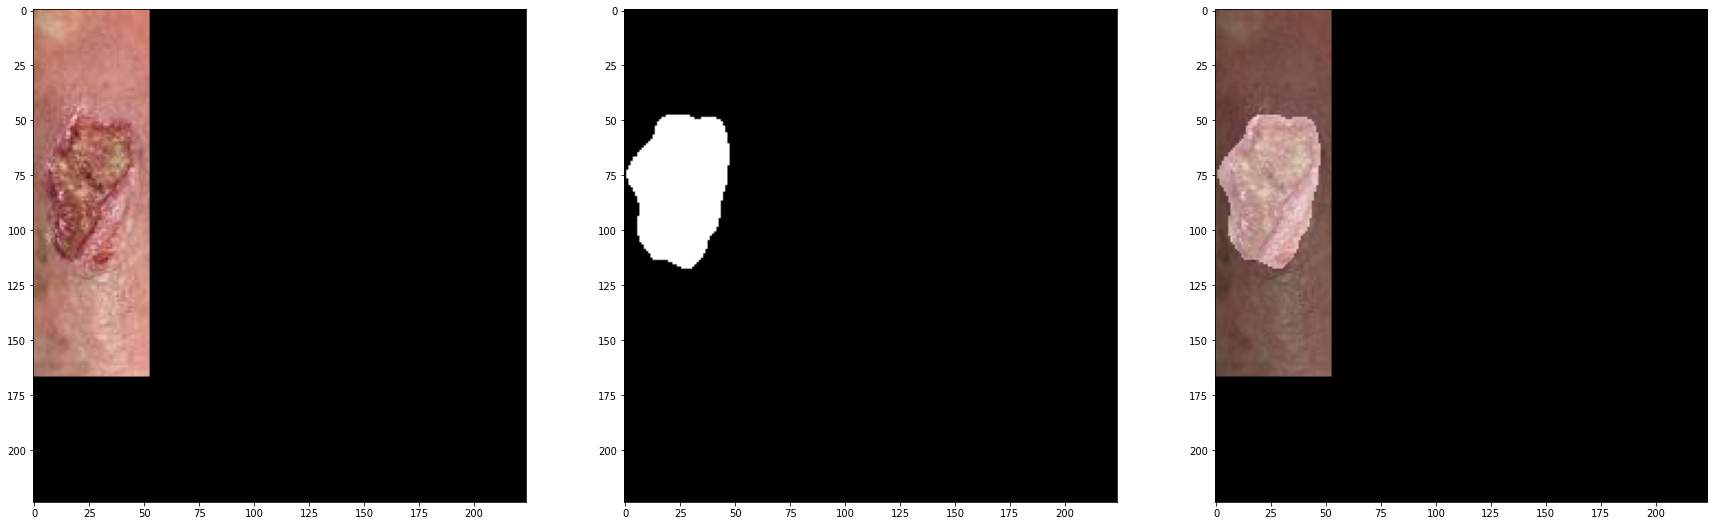

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30,10))
nroImg = 50
img = np.load(imgs_test[nroImg])
mask = np.load(masks_test[nroImg])


ax1.imshow(img)
ax2.imshow(mask)
ax3.imshow(img)
ax3.imshow(mask, alpha=0.4)
plt.show()

Analizo las dimensiones:


In [ ]:
img.shape, img.dtype, img.max(), img.min()

((224, 224, 3), dtype('uint8'), 255, 0)

In [ ]:
mask.shape, mask.dtype, mask.max(), mask.min()

((224, 224, 3), dtype('uint8'), 255, 0)

# Pre - Procesamiento

## Quiero ver de pasar del train las labels de RGB a binary 0 o 1

In [ ]:
def RGBPuro2BinarioX1(RGB): # FUNCIONA SOLO PARA RGBPURO de input"

      if (RGB ==  np.array([255,255,255])).all():
              RGB = ([1])
      else:
              RGB = ([0])
      return RGB # devuelve un 1x1


Le aplico la función a todas las máscaras de train. Ojo q tarda mucho ! como 9 min.

In [ ]:

clasesX1 = []
for i in range (len(masks_train)): # i va a tomar valores de 0 a 16
   # mask = np.load(masks[i])
   
   mask_train = np.load(masks_train[i]) # leo los archivos.npy y obtengo el numpy array de ellos
   claseX1 = np.zeros((mask_train.shape[0],mask_train.shape[1],1 ))

   for h in range (mask_train.shape[0]-1): # itero por height, si la shape de la mask es por ejemplo (482, 560, 3), h debe tomar valores entre 0 y 481. (las shapes no son todas iguales...)
     for w  in range (mask_train.shape[1]-1):
       mask_train[h][w] = RGBPuro2BinarioX1(mask_train[h][w]) 
       claseX1[h][w] = np.max(mask_train[h][w]) #uso np.nax xq si no me da en 1x3 el mismo num repetido en lugar de en 1x1 

       
  #clasesX1.append(np.array(maskRGBPuro))
   clasesX1.append(np.array(claseX1))

Creo carpeta con estas nuevas mascaras como archivos .npy, a las que después puedo acceder a partir de np.load(masksBinaryX1[i]), donde i es el indice del orden de cada imagen que concuerda con las otras imagenes de train (de forma que coinciden con estas labels o masks)

In [ ]:
p4 = Path(path_train/'labels_bin_npy')
p4.mkdir(parents=True, exist_ok=True)

for count, i in enumerate(os.listdir(path_train/'labels_npy')):
   #print(count)
   numpydata = clasesX1[count] # le cargo los datos son RGBPuro
   npyfile = str(masksBinaryX1[count]).split(".")[0]
   np.save(npyfile, numpydata)  
  

## Creo un train_generator que contiene las imagenes y labels pero en 150x150 (o lo que elija) y en batches de 20


DUDA : esto está hecho también para las máscaras originales en RGB. Debería hacerlo sobre las binariasX1? Si voy a entrenar el modelo con imagenes en una resolución distina, las labels tendrían que ser de esa misma resolución y en lugar de RGB en mascara binaria X1. El validation_generator por otro lado saca imágenes del test y yo el cambio de mascaras lo hice solo para train por ahora

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        #train_dir,
        "/content/train",

        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode = "input" )

validation_generator = test_datagen.flow_from_directory(
        "/content/test",
        target_size=(150, 150),
        batch_size=20,
        class_mode = "input")

Found 1662 images belonging to 5 classes.
Found 556 images belonging to 4 classes.


data batch shape: (20, 150, 150, 3)
labels batch shape: (20, 150, 150, 3)


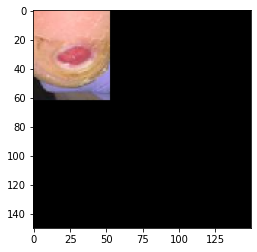

In [ ]:
from keras.preprocessing import image

for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    plt.imshow(image.array_to_img(data_batch[0]))
    #plt.imshow(image.array_to_img(labels_batch[0]))
    break

# Prueba Sensio Melanoma:

Para esta parte solo necesito correr la primera línea donde extraigo el zip de GDrive

Creo un dataset que contenga los nombres de mis archivos --> ya lo tengo?? uno para train con el nombre del archivo y de su mascara , q deberia ser igual creo y lo mismo para test. Esto me va a permitir hacer el train test split y crear el val_set a partir del df que creé de train.


Creo un dataset con los nombres de las imágenes y de sus labels (coinciden en este caso)
Notar que para hacer esto en ningun momento me meto en la carpeta train/labels, xq yo ya veo q tienen q tener el mismo nombre, entonces uso directamente la de images para ambas columnas

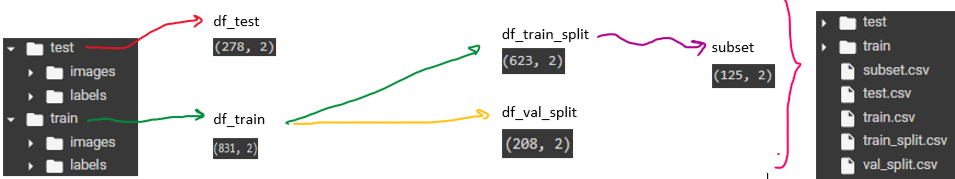

In [2]:
import pandas as pd
import os

df_train = pd.DataFrame()

nombres_imagenes = os.listdir("/content/train/images")
nombres_etiquetas =[ix_imagen for ix_imagen in os.listdir("/content/train/images")] # en este caso mi referencia es el nombre completo, incluso la extension xq se llaman igual las imagenes a sus labels y son el mismo tipo de archivo.

# aca como los nombres son exactamente iguales , no hacía falta la línea de arriba podía driectamente crear dos columnas con los mismos valores:
# nombres_etiquetas = os.listdir("/content/train/images")


df_train['image_name'] = nombres_imagenes
df_train['label_name'] = nombres_etiquetas

df_train

df_train.shape

(831, 2)

Creo un dataset igual pero para el test

In [3]:
import pandas as pd

df_test = pd.DataFrame()

nombres_imagenes = os.listdir("/content/test/images")
nombres_etiquetas =[ix_imagen for ix_imagen in os.listdir("/content/test/images")] # en este caso mi referencia es el nombre completo, incluso la extension xq se llaman igual las imagenes a sus labels y son el mismo tipo de archivo.

# aca como los nombres son exactamente iguales , no hacía falta la línea de arriba podía driectamente crear dos columnas con los mismos valores:
# nombres_etiquetas = os.listdir("/content/train/images")


df_test['image_name'] = nombres_imagenes
df_test['label_name'] = nombres_etiquetas

df_test

df_test.shape

(278, 2)

Del df_train, hago un split para tener df_train_split y df_val_split

In [4]:
from sklearn.model_selection import train_test_split

df_train_split , df_val_split = train_test_split(df_train, test_size = 0.25, shuffle = True, random_state = 42)
# con el validation voy viendo las métricas a medida que entreno

# el test_size (ratio) lo pongo en 1/3 porque sigue mi ratio de train test.
# EN REALIDAD DEBERÍA HABER SIDO 1/4 SIGUIENDO ESTA IDEA PERO SENSIO LO PUSO ASÍ.

# random state está bueno para comparar modelos (es como la seed) siempre que ponga el mismo número
# voy a tener las mismas imágenes de validation.

# stratify me mantiene la proporción de targets. ek 98% de las imágenes 
# de train y validation tienen clase 0 y el 2% restante clase 1
# El stratify lo hago en función de la columna target(por eso se la paso por parám.

df_train_split.shape, df_val_split.shape

((623, 2), (208, 2))

Ahora teniendo esto puedo usar mis dataframes con los nombres ya separados para acceder a los archivos con sus splits de forma ordenada 

In [5]:
# USO SUBSET de mi split PARA EVALUAR CAMBIOS QUE PIENSO IMPLEMENTAR de forma rápida
_, subset = train_test_split(df_train_split, test_size = 0.2, shuffle = True, random_state = 42)
subset.shape

(125, 2)

In [6]:
PATH = "/content"
df_train.to_csv(f"{PATH}/train.csv", index = False)
df_test.to_csv(f"{PATH}/test.csv", index = False)
df_train_split.to_csv(f"{PATH}/train_split.csv", index = False)
df_val_split.to_csv(f"{PATH}/val_split.csv", index = False)
subset.to_csv(f"{PATH}/subset.csv", index = False)
# index False para que no me guarde la columna de lo